## Dataset Setup

In [30]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Set random seeds for reproducibility
SEED = 3
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set the desired activation function
AF = 'relu'

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

Running on Python Version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
Using Tensorflow Version: 2.6.2
Using GPU at: /device:GPU:0 (of 1 available)


In [31]:
# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/Mluckydwyer/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

## Working with the Dataset

In [32]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the clas
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Validation: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>

--- Show an example image ---


Label: b'mantis, mantid' (class index: 51 - id: b'n02236044')

 Show some other examples


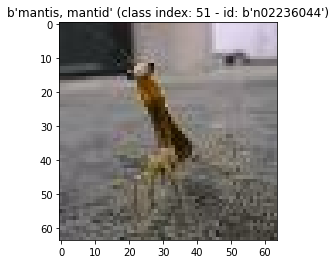

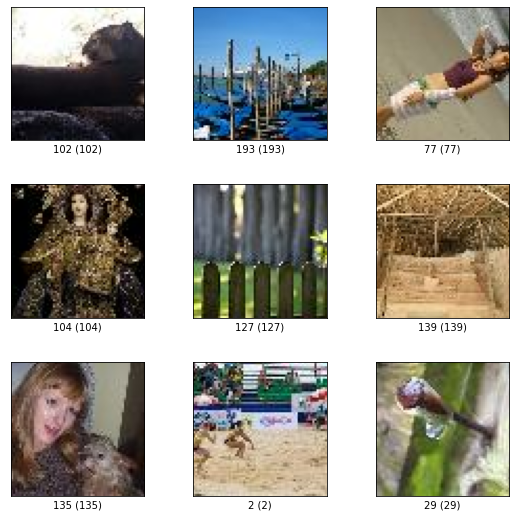

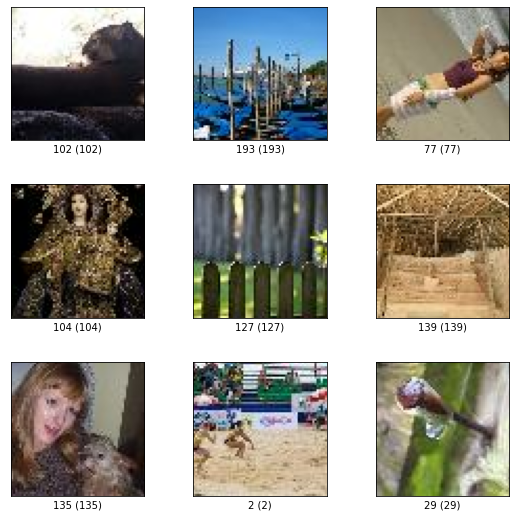

In [33]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'bucket, pail' (class index: 190 - id: b'n02909870')

--- Image 1 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'ice lolly, lolly, lollipop, popsicle' (class index: 121 - id: b'n07615774')

--- Image 2 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'sandal' (class index: 97 - id: b'n04133789')


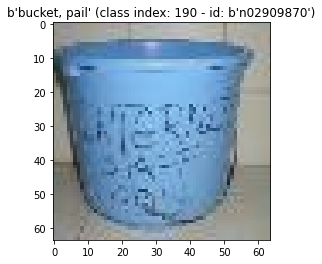

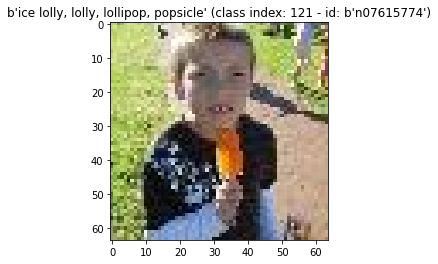

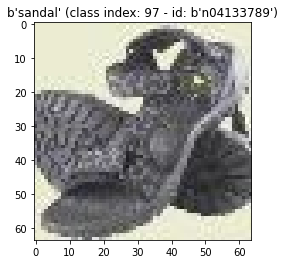

In [34]:
#     : Print and visualize three inputs from the validation set
#     : Print the storage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.take(3)):
    # img_data["image"] = tf.cast(img_data["image"], tf.float32) / 255
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    # Your Code Here
    print(f"Image Data Type: {image.dtype}")
    print(f"Image Shape: {image.shape}")
    print(f"Image Memory: {image.numpy().nbytes} bytes")
    img_info(img_data)

In [35]:
# Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

def export_sample_imgs_orig():
    # Make a directory for our image data
    img_dir = os.path.abspath('data_' + AF)
    pathlib.Path(img_dir).mkdir(exist_ok=True)

    # Create a metadata file
    metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
    metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

    # Export each image
    for index, img_data in enumerate(sample_imgs):
        img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')

        # cast to float32 to match the C++ code
        image = tf.cast(img_data["image"], tf.float32)
        print(image.shape)
        print(image.numpy().nbytes)

        # Write the image to the file
        img_file.write(image)
        img_file.close()

        # Write the image metadata for reference later
        class_str = img_class(img_data)
        metadata_file.write(f'{index}\t\t{image.shape}\t\t{class_str}\n')
    metadata_file.close()

def export_sample_imgs_quant():
    # Make a directory for our image data
    img_dir = os.path.abspath('data_quant_' + AF)
    pathlib.Path(img_dir).mkdir(exist_ok=True)

    # Create a metadata file
    metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
    metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

    # Export each image
    for index, img_data in enumerate(sample_imgs):
        img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')

        # keep image in uint8 fromat to match the C++ code
        image = tf.cast(img_data["image"], tf.uint8)
        print(image.shape)
        print(image.numpy().nbytes)

        # Write the image to the file
        img_file.write(image)
        img_file.close()

        # Write the image metadata for reference later
        class_str = img_class(img_data)
        metadata_file.write(f'{index}\t\t{image.shape}\t\t{class_str}\n')
    metadata_file.close()

def export_sample_imgs_quant2():
    # Make a directory for our image data
    img_dir = os.path.abspath('data_quant2_' + AF)
    pathlib.Path(img_dir).mkdir(exist_ok=True)

    # Create a metadata file
    metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
    metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

    # Export each image
    for index, img_data in enumerate(sample_imgs):
        img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')

        # cast to float32 to match the C++ code
        image = tf.cast(img_data["image"], tf.float32)
        print(image.shape)
        print(image.numpy().nbytes)

        # Write the image to the file
        img_file.write(image)
        img_file.close()

        # Write the image metadata for reference later
        class_str = img_class(img_data)
        metadata_file.write(f'{index}\t\t{image.shape}\t\t{class_str}\n')
    metadata_file.close()

export_sample_imgs_quant()
export_sample_imgs_quant2()


(64, 64, 3)
12288
(64, 64, 3)
12288
(64, 64, 3)
12288
(64, 64, 3)
49152
(64, 64, 3)
49152
(64, 64, 3)
49152


In [36]:
# define function to print top n accuracy
def print_top_n_accuracy(n, ds_val, model, batch_size=32):
    total = acc_top_n = 0

    for batch in ds_val.batch(batch_size):
        # Make a prediction
        pred = model.predict(batch["image"].numpy())
        top_n = tf.math.top_k(pred, k=n).indices
        
        # np.isin() returns a boolean array where the value is True if the element of the first input is in the second input
        # np.sum() sums the boolean array, which is the same as counting the number of True values
        acc_top_n += np.sum(np.isin(batch["label"].numpy(), top_n))
        
        total += len(batch["label"].numpy())

    print(f'Top-{n} Accuracy: {acc_top_n / total}, total images: {total}')


In [37]:
# Print all of the possible classes of the dataset and report how many there are in each split (train + validation)

# count all the unique classes in a dataset
def count_class(ds):
    class_count = {}
    num_unique = 0
    for img_data in ds:
        label = img_data["label"].numpy()
        if label in class_count:
            class_count[label] += 1
        else:
            class_count[label] = 1
            num_unique += 1
    return class_count, num_unique

# sum the class counts for each split
class_counts_train, count_unique_train = count_class(ds_train)
class_counts_val, count_unique_val = count_class(ds_val)

# Print all the classes present in the entire dataset
print(f'Entire dataset class IDs: {ds_info.features["label"].names}')
print(f'Number of classes in entire dataset: {len(ds_info.features["label"].names)}')

# Print the number of classes in each split
print(f'Number of unique Classes in Train: {count_unique_train}')
print(f'Number of unique Classes in Validation: {count_unique_val}')

# print the total number of images in the dataset
# print(f'Total number of images in dataset: {ds_info.splits["train"].num_examples + ds_info.splits["validation"].num_examples}')
print(f'Total number of images in dataset: {len(ds_train) + len(ds_val)}')


Entire dataset class IDs: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154'

## Model Initializations

In [38]:
# Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

model_tiny_path = os.path.abspath("CNN_TinyImageNet_2.h5")

# Your Code Here
model_tiny = tf.keras.models.load_model(model_tiny_path)

# Print a summary of the model
# NOTE: https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/Model
model_tiny.summary()

# get total parameters from model
total_params = model_tiny.count_params()
print(f'Total parameters: {total_params}')
# print memory sizes for fp32, fp16, int8, int4, int2, int1
print(f'FP32 memory: {total_params * 4 / 1024} KB')
print(f'FP16 memory: {total_params * 2 / 1024} KB')
print(f'INT8 memory: {total_params * 1 / 1024} KB')
print(f'INT4 memory: {total_params * 0.5 / 1024} KB')
print(f'INT2 memory: {total_params * 0.25 / 1024} KB')

# print size of each initermediate layer for 8-bit quantization
scale = 1
layer_mem = 64 * 64 * 3 * scale / 1024
for layer in model_tiny.layers:
    cur_layer_mem = layer.output.shape[1]
    for i in range(len(layer.output.shape) - 2):
        cur_layer_mem *= layer.output.shape[i + 2]
    cur_layer_mem *= scale / 1024
    layer_mem += cur_layer_mem
print(f'Layers memory: {layer_mem} KB')
print(f'Total memory: {layer_mem + (total_params * scale / 1024)} KB')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

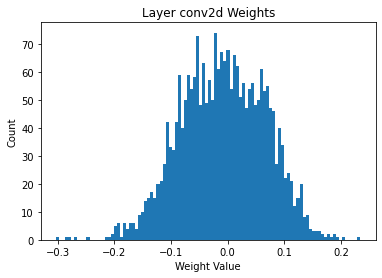

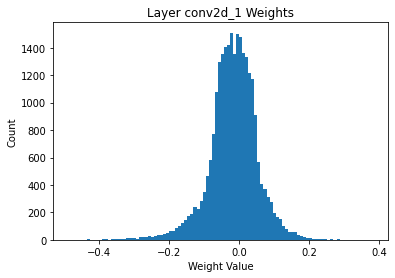

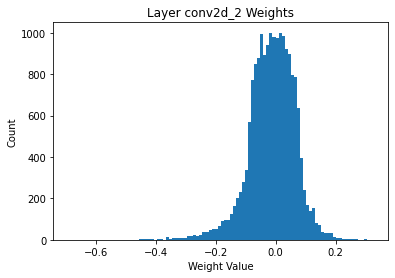

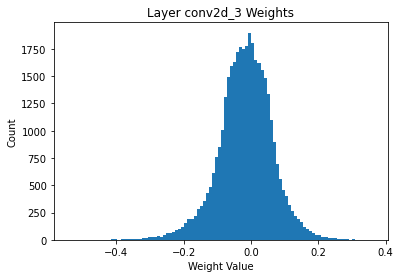

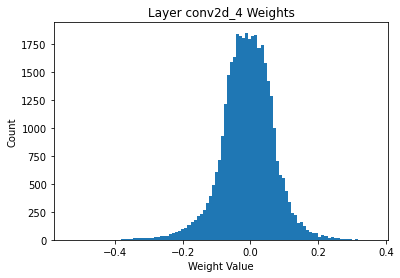

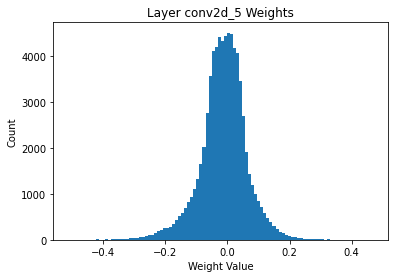

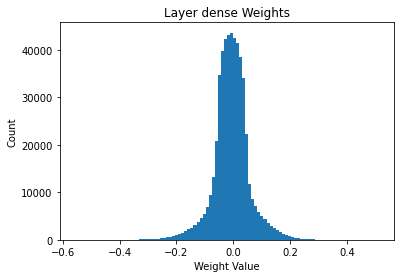

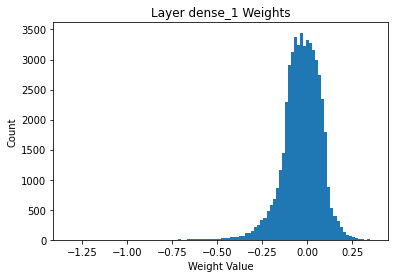

Layer conv2d Weights
Min: -0.30287936329841614, Max: 0.23425443470478058
Layer conv2d Biases
Min: -0.05726848915219307, Max: 0.0976124033331871

Layer conv2d_1 Weights
Min: -0.48677802085876465, Max: 0.3825509250164032
Layer conv2d_1 Biases
Min: -0.07017958909273148, Max: 0.0955795869231224

Layer conv2d_2 Weights
Min: -0.6923781633377075, Max: 0.3248261511325836
Layer conv2d_2 Biases
Min: -0.20990024507045746, Max: 0.1523394137620926

Layer conv2d_3 Weights
Min: -0.5415472388267517, Max: 0.36290860176086426
Layer conv2d_3 Biases
Min: -0.2958078682422638, Max: 0.10222853720188141

Layer conv2d_4 Weights
Min: -0.5366791486740112, Max: 0.3624016344547272
Layer conv2d_4 Biases
Min: -0.317999005317688, Max: 0.1806652545928955

Layer conv2d_5 Weights
Min: -0.5106551647186279, Max: 0.46819156408309937
Layer conv2d_5 Biases
Min: -0.13614007830619812, Max: 0.2128349095582962

Layer dense Weights
Min: -0.5575851202011108, Max: 0.512802243232727
Layer dense Biases
Min: -0.1793096661567688, Max: 

In [39]:
# for each layer having non-zero weights, plot the distribution of weights

# get layer names
layer_names = []
for layer in model_tiny.layers:
    layer_names.append(layer.name)

# get all weights from model
all_weights = []
for layer in model_tiny.layers:
    all_weights.append(layer.get_weights())

# plot the distribution of weights for each layer
for i in range(len(all_weights)):
    if len(all_weights[i]) > 0:
        # print(all_weights[i][0].shape)
        plt.figure()
        plt.hist(all_weights[i][0].flatten(), bins=100)
        plt.title(f'Layer {layer_names[i]} Weights')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')
        plt.show()

# show the min and max values of weights and biases for each layer
max_abs_weights_per_layer = []
max_abs_biases_per_layer = []
for i in range(len(all_weights)):
    if len(all_weights[i]) > 0:
        print(f'Layer {layer_names[i]} Weights')
        max_abs_weights_per_layer.append(np.max(np.abs(all_weights[i][0])))
        print(f'Min: {np.min(all_weights[i][0])}, Max: {np.max(all_weights[i][0])}')
        print(f'Layer {layer_names[i]} Biases')
        max_abs_biases_per_layer.append(np.max(np.abs(all_weights[i][1])))
        print(f'Min: {np.min(all_weights[i][1])}, Max: {np.max(all_weights[i][1])}')
        print()
    else:
        max_abs_weights_per_layer.append(0)
        max_abs_biases_per_layer.append(0)

for i in range(len(max_abs_weights_per_layer)):
    print(f'Layer {layer_names[i]} Max Abs Weight: {max_abs_weights_per_layer[i]}')
    print(f'Layer {layer_names[i]} Max Abs Bias: {max_abs_biases_per_layer[i]}')
    print()


In [40]:
# Using 1000 random images form the dataset, find overall min and max values of the activations for each layer
# Assume the range of input is between 0 and 1
# METHOD 1

# get 1000 random images from the dataset
# rand_imgs = []
# for i in range(1000):
#     rand_imgs.append(ds_train.take(1))
rand_imgs = ds_train.batch(1).take(1000)

# TODO ssz normalize the input to be between 0 and 1?
# for img in rand_imgs:
#     img["image"] = tf.cast(img["image"], tf.float32) / 255

# get all layer outputs and create a model to get activations
layer_outputs = [layer.output for layer in model_tiny.layers]
activations_model = Model(inputs=model_tiny.input, outputs=layer_outputs)

# * get activations for each convolutional and dense layers (not pooling nor flatten)
all_activations = [[] for i in range(len(model_tiny.layers))]
min_max_activations = [[] for i in range(len(model_tiny.layers))]
for img in rand_imgs:
    activations = activations_model.predict(img["image"])
    for i in range(len(activations)):
        act = activations[i].flatten().tolist()
        # if ("conv" in layer_names[i] or "dense" in layer_names[i]):
        all_activations[i].extend(act)
        min_act = np.min(act)
        max_act = np.max(act)
        if (len(min_max_activations[i]) == 0):
            min_max_activations[i].extend([min_act, max_act])
        else:
            if (min_act < min_max_activations[i][0]):
                min_max_activations[i][0] = min_act
            if (max_act > min_max_activations[i][1]):
                min_max_activations[i][1] = max_act

print(f"Number of layers of min/max activations: {len(min_max_activations)}")
for i in range(len(min_max_activations)):
    print(f'Layer {layer_names[i]} Min/Max Activations')
    print(min_max_activations[i])


Number of layers of min/max activations: 12
Layer conv2d Min/Max Activations
[0.0, 426.3996887207031]
Layer conv2d_1 Min/Max Activations
[0.0, 1040.7908935546875]
Layer max_pooling2d Min/Max Activations
[0.0, 1040.7908935546875]
Layer conv2d_2 Min/Max Activations
[0.0, 760.5674438476562]
Layer conv2d_3 Min/Max Activations
[0.0, 870.2926025390625]
Layer max_pooling2d_1 Min/Max Activations
[0.0, 870.2926025390625]
Layer conv2d_4 Min/Max Activations
[0.0, 1560.6925048828125]
Layer conv2d_5 Min/Max Activations
[0.0, 1976.5955810546875]
Layer max_pooling2d_2 Min/Max Activations
[0.0, 1976.5955810546875]
Layer flatten Min/Max Activations
[0.0, 1976.5955810546875]
Layer dense Min/Max Activations
[0.0, 2939.211669921875]
Layer dense_1 Min/Max Activations
[0.0, 1.0]


In [41]:

# Implement linear quantization
# activations are in the range on unsigned integer 8-bit (uint8) [0, 255]
# weights are in signed integer 8-bit (int8) [-128, 127]
# biases are in signed integer 32-bit (int32) [-2147483648, 2147483647]

# to quantize weights, inputs, and biases of layer l, calculate the scales to quantize as follows:
# scale_weights_l = 127 / max(abs(weight_l))
# scale_inputs_l = 255 / max(abs(input_l))
# scale_biases_l = scale_inputs_l * scale_weights_l
# where weight_l and input_l are flattened weight and input fp32 vectors of layer l.

# Then, compute comrresponding integer quantized values as follows:
# int8_weights_l = round(scale_weights_l * weight_l)
# uint8_inputs_l = round(scale_inputs_l * input_l)
# int32_biases_l = round(scale_biases_l * biases_l)

# The output is accumulated in int32 data types
# After each layer, since the output is int32, we need to convert activations back to uint8.
# Must 1st dequantize to fp32 values by dividing with quantization scale (scale_input * scale_weights)
# and then requantize the fp32 value back to uint8 for the next layers using min-max fp32 activations

scale_weights_l = []
scale_inputs_l = []
scale_biases_l = []

int8_weights_l = []
uint8_inputs_l = []
int32_biases_l = []

# get scales for each layer
# 2 conv, 1 maxpool, 2 conv, 1 maxpool, 2 conv, 1 maxpool, 1 flatten, 2 dense
# min_max_activations has all layers
for i in range(len(max_abs_weights_per_layer)):
    if (max_abs_weights_per_layer[i] == 0):
        scale_weights_l.append(0)
        scale_inputs_l.append(1)
        scale_biases_l.append(0)
    else:
        scale_weights_l.append(127 / max_abs_weights_per_layer[i])
        scale_inputs_l.append(255 / min_max_activations[i][1])
        scale_biases_l.append(scale_inputs_l[i] * scale_weights_l[i])


# get integer quantized values for each layer
for i in range(len(all_weights)):
    if len(all_weights[i]) > 0:
        # cast to int8 and int32
        int8_weights_l.append(tf.cast(np.round(scale_weights_l[i] * all_weights[i][0]), tf.int8))
        int32_biases_l.append(tf.cast(np.round(scale_biases_l[i] * all_weights[i][1]), tf.int32))
    else:
        int8_weights_l.append([])
        int32_biases_l.append([])

# get uint8 inputs for each layer of the 1000 random training images
for i in range(len(all_activations)):
    uint8_inputs_l.append(tf.cast(np.round(scale_inputs_l[i] * np.array(all_activations[i])), tf.uint8))


In [42]:
# print the scales for each layer
for i in range(len(scale_weights_l)):
    print(f'Layer {layer_names[i]} Scales')
    print(f'Scale Weights: {scale_weights_l[i]}')
    print(f'Scale Inputs: {scale_inputs_l[i]}')
    print(f'Scale Biases: {scale_biases_l[i]}')
    print()

# print the integer quantized values for each layer
for i in range(len(int8_weights_l)):
    print(f'Layer {layer_names[i]} Integer Quantized Values')
    print(f'Int8 Weights: {int8_weights_l[i]}')
    print(f'Int32 Biases: {int32_biases_l[i]}')
    print()


Layer conv2d Scales
Scale Weights: 419.3088582098988
Scale Inputs: 0.5980304553341924
Scale Biases: 250.7594674009261

Layer conv2d_1 Scales
Scale Weights: 260.8992077660963
Scale Inputs: 0.24500598686935113
Scale Biases: 63.921867872164306

Layer max_pooling2d Scales
Scale Weights: 0
Scale Inputs: 1
Scale Biases: 0

Layer conv2d_2 Scales
Scale Weights: 183.42577326208328
Scale Inputs: 0.3352759864529216
Scale Biases: 61.498257071334905

Layer conv2d_3 Scales
Scale Weights: 234.51324444962967
Scale Inputs: 0.29300490347274266
Scale Biases: 68.71353055304344

Layer max_pooling2d_1 Scales
Scale Weights: 0
Scale Inputs: 1
Scale Biases: 0

Layer conv2d_4 Scales
Scale Weights: 236.64045885476003
Scale Inputs: 0.16338900789374083
Scale Biases: 38.66444979979884

Layer conv2d_5 Scales
Scale Weights: 248.70011854276902
Scale Inputs: 0.1290096985160389
Scale Biases: 32.08472731410577

Layer max_pooling2d_2 Scales
Scale Weights: 0
Scale Inputs: 1
Scale Biases: 0

Layer flatten Scales
Scale Weigh

## Export Weights and Layer Output Data

In [43]:
# Export the filters/weights for the original version
def export_weights_biases_orig():
    model_dir = os.path.abspath('data_' + AF + '/model')
    pathlib.Path(model_dir).mkdir(exist_ok=True)

    # Export each image
    conv_index = dense_index = 1 # layer index starts from one
    for layer_idx, layer in enumerate(model_tiny.layers):
        if re.match("conv", layer.name):
            weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'conv{conv_index}_biases.bin')
            conv_index += 1
        elif re.match("dense", layer.name):
            weight_file_name = os.path.join(model_dir, f'dense{dense_index}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'dense{dense_index}_biases.bin')
            dense_index += 1
        else:
            continue
        # Flatten the image
        weights = layer.get_weights()[0].flatten()
        biases = layer.get_weights()[1].flatten()
        # Write the image to the file
        weight_file = open(weight_file_name, 'wb')
        weight_file.write(weights)
        weight_file.close()
        
        bias_file = open(bias_file_name, 'wb')
        bias_file.write(biases)
        bias_file.close()

    print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")


# Export the filters/weights for the quantized version
def export_weights_biases_quant():
    model_dir = os.path.abspath('data_quant_' + AF + '/model')
    pathlib.Path(model_dir).mkdir(exist_ok=True)

    # Export each image
    conv_index = dense_index = 1 # layer index starts from one
    for layer_idx, layer in enumerate(model_tiny.layers):
        if re.match("conv", layer.name):
            weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'conv{conv_index}_biases.bin')
            conv_index += 1
        elif re.match("dense", layer.name):
            weight_file_name = os.path.join(model_dir, f'dense{dense_index}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'dense{dense_index}_biases.bin')
            dense_index += 1
        else:
            continue
        # Flatten the image
        weights = int8_weights_l[layer_idx]
        biases = int32_biases_l[layer_idx]
        print(weights.shape)
        print(biases.shape)
        # Write the image to the file
        weight_file = open(weight_file_name, 'wb')
        weight_file.write(weights)
        weight_file.close()
        
        bias_file = open(bias_file_name, 'wb')
        bias_file.write(biases)
        bias_file.close()

    print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")

# Export the filters/weights for the quantized version
def export_weights_biases_quant2():
    model_dir = os.path.abspath('data_quant2_' + AF + '/model')
    pathlib.Path(model_dir).mkdir(exist_ok=True)

    # Export each image
    conv_index = dense_index = 1 # layer index starts from one
    for layer_idx, layer in enumerate(model_tiny.layers):
        if re.match("conv", layer.name):
            weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'conv{conv_index}_biases.bin')
            conv_index += 1
        elif re.match("dense", layer.name):
            weight_file_name = os.path.join(model_dir, f'dense{dense_index}_weights.bin')
            bias_file_name = os.path.join(model_dir, f'dense{dense_index}_biases.bin')
            dense_index += 1
        else:
            continue
        # Flatten the image
        weights = int8_weights_l[layer_idx]
        biases = int32_biases_l[layer_idx]
        print(weights.shape)
        print(biases.shape)
        # Write the image to the file
        weight_file = open(weight_file_name, 'wb')
        weight_file.write(weights)
        weight_file.close()
        
        bias_file = open(bias_file_name, 'wb')
        bias_file.write(biases)
        bias_file.close()

    print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")

export_weights_biases_quant()
export_weights_biases_quant2()


(5, 5, 3, 32)
(32,)
(5, 5, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(2048, 256)
(256,)
(256, 200)
(200,)
All the convolution and dense (fully connected) weights and biases successfully exported to input folders in /home/sszabo/github/CPRE587/lab4/sw/data_quant_relu/model directory
(5, 5, 3, 32)
(32,)
(5, 5, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(2048, 256)
(256,)
(256, 200)
(200,)
All the convolution and dense (fully connected) weights and biases successfully exported to input folders in /home/sszabo/github/CPRE587/lab4/sw/data_quant2_relu/model directory


In [44]:
# Export the intermediate layer outputs for each of the input for all of the layers for the original version
def export_intermediate_outputs_orig():
    img_dir = os.path.abspath('data_' + AF)
    pathlib.Path(img_dir).mkdir(exist_ok=True)

    for img_idx, img in enumerate(sample_imgs):
        file_dir = os.path.join(img_dir, f'image_{img_idx}_data')
        pathlib.Path(file_dir).mkdir(exist_ok=True)
        
        for layer_idx, layer in enumerate(model_tiny.layers):
            aux_model = tf.keras.Model(inputs=model_tiny.inputs, outputs=[layer.output])
            
            # Store the intermediate output as float32
            img["image"] = tf.cast(img["image"], tf.float32)
            output = aux_model.predict(img["image"].numpy().reshape(1, 64, 64, 3)).flatten().astype(np.float32)
            print(output.shape)
            print(output.dtype)
            print(output.nbytes)
            
            output_file_name = os.path.join(file_dir, f'layer_{layer_idx}_output.bin')
            output_file = open(output_file_name, 'wb')
            output_file.write(output)
            output_file.close()

    print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")


# Export the intermediate layer outputs for each of the input for all of the layers for the quantized version
# exports original fp32 data as uint8
def export_intermediate_outputs_quant():
    img_dir = os.path.abspath('data_quant_' + AF)
    pathlib.Path(img_dir).mkdir(exist_ok=True)

    for img_idx, img in enumerate(sample_imgs):
        file_dir = os.path.join(img_dir, f'image_{img_idx}_data')
        pathlib.Path(file_dir).mkdir(exist_ok=True)
        
        for layer_idx, layer in enumerate(model_tiny.layers):
            aux_model = tf.keras.Model(inputs=model_tiny.inputs, outputs=[layer.output])
            
            # store the intermediate output as uint8
            # TODO ssz store output differently?
            output = aux_model.predict(img["image"].numpy().reshape(1, 64, 64, 3)).flatten().astype(np.uint8)
            # quantize to ui8 using min-max fp32 activations
            # output = tf.cast(np.round(scale_inputs_l[layer_idx] * output), tf.uint8)
            # print(output.shape)
            # print(output.dtype)
            # print(output.nbytes)
            
            output_file_name = os.path.join(file_dir, f'layer_{layer_idx}_output.bin')
            output_file = open(output_file_name, 'wb')
            output_file.write(output)
            output_file.close()
            
    print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")


def export_intermediate_outputs_quant2():
    img_dir = os.path.abspath('data_quant2_' + AF)
    pathlib.Path(img_dir).mkdir(exist_ok=True)

    for img_idx, img in enumerate(sample_imgs):
        file_dir = os.path.join(img_dir, f'image_{img_idx}_data')
        pathlib.Path(file_dir).mkdir(exist_ok=True)
        
        for layer_idx, layer in enumerate(model_tiny.layers):
            aux_model = tf.keras.Model(inputs=model_tiny.inputs, outputs=[layer.output])
            
            # Store the intermediate output as float32
            img["image"] = tf.cast(img["image"], tf.float32)
            output = aux_model.predict(img["image"].numpy().reshape(1, 64, 64, 3)).flatten().astype(np.float32)
            print(output.shape)
            print(output.dtype)
            print(output.nbytes)
            
            output_file_name = os.path.join(file_dir, f'layer_{layer_idx}_output.bin')
            output_file = open(output_file_name, 'wb')
            output_file.write(output)
            output_file.close()

    print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")

export_intermediate_outputs_quant()
export_intermediate_outputs_quant2()


All the corresponding intermediate layer outputs successfully exported to each input folder in the /home/sszabo/github/CPRE587/lab4/sw/data_quant_relu directory
(115200,)
float32
460800
(100352,)
float32
401408
(25088,)
float32
100352
(43264,)
float32
173056
(36864,)
float32
147456
(9216,)
float32
36864
(6400,)
float32
25600
(8192,)
float32
32768
(2048,)
float32
8192
(2048,)
float32
8192
(256,)
float32
1024
(200,)
float32
800
(115200,)
float32
460800
(100352,)
float32
401408
(25088,)
float32
100352
(43264,)
float32
173056
(36864,)
float32
147456
(9216,)
float32
36864
(6400,)
float32
25600
(8192,)
float32
32768
(2048,)
float32
8192
(2048,)
float32
8192
(256,)
float32
1024
(200,)
float32
800
(115200,)
float32
460800
(100352,)
float32
401408
(25088,)
float32
100352
(43264,)
float32
173056
(36864,)
float32
147456
(9216,)
float32
36864
(6400,)
float32
25600
(8192,)
float32
32768
(2048,)
float32
8192
(2048,)
float32
8192
(256,)
float32
1024
(200,)
float32
800
All the corresponding intermedia